In [391]:
#import statements
import pandas as pd
import seaborn as sns
import numpy as np
import time
import gc
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, SimpleRNN, GRU, LSTM, Bidirectional

In [392]:
#reading file
tweetData = pd.read_csv("Twitter.csv")

In [393]:
print(tweetData.head())

   longitude   latitude       timestamp  timezone
0 -87.895450  43.063007  20130112000000         2
1 -93.674799  45.025114  20130112000000         2
2 -97.104568  32.709685  20130112000000         2
3 -71.120095  42.351453  20130112000000         1
4 -79.048690  43.100826  20130112000000         1


In [394]:
print(tweetData.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14262517 entries, 0 to 14262516
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   longitude  float64
 1   latitude   float64
 2   timestamp  int64  
 3   timezone   int64  
dtypes: float64(2), int64(2)
memory usage: 435.3 MB
None


In [395]:
print(tweetData.describe())

          longitude      latitude     timestamp      timezone
count  1.426252e+07  1.426252e+07  1.426252e+07  1.426252e+07
mean  -9.001149e+01  3.726753e+01  2.013012e+13  1.801275e+00
std    1.434863e+01  4.817290e+00  1.991052e+06  1.045891e+00
min   -1.246282e+02  2.527794e+01  2.013011e+13  1.000000e+00
25%   -9.669478e+01  3.375185e+01  2.013011e+13  1.000000e+00
50%   -8.568290e+01  3.804012e+01  2.013012e+13  1.000000e+00
75%   -7.998525e+01  4.114987e+01  2.013012e+13  2.000000e+00
max   -6.717232e+01  4.933835e+01  2.013012e+13  4.000000e+00


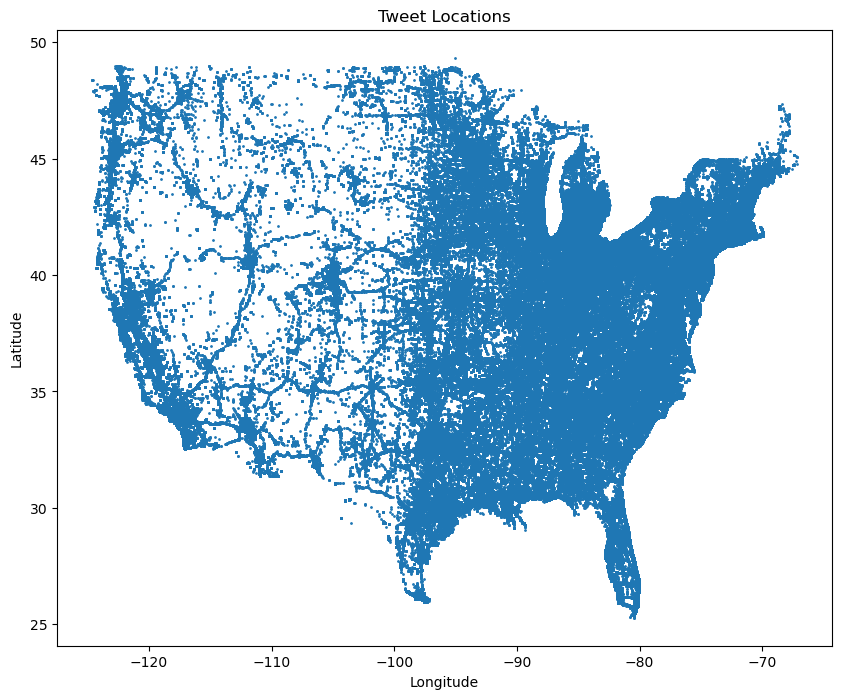

In [396]:
#Plot of distribution of tweet locations
plt.figure(figsize=(10, 8))
plt.scatter(tweetData['longitude'], tweetData['latitude'], s=1) 
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Tweet Locations")
plt.show()

In [397]:
#function to assign grid
gridCellSize = 0.2

def assignGridId(row):
    latitudeBin = np.floor(row['latitude'] / gridCellSize)  
    longitudeBin = np.floor(row['longitude'] / gridCellSize) 
    return f"lat_{int(latitudeBin)}_lon_{int(longitudeBin)}"

tweetData['gridId'] = tweetData.apply(assignGridId, axis=1) 

In [398]:
#Formatting timestamp
tweetData['timestamp'] = pd.to_datetime(tweetData['timestamp'], format='%Y%m%d%H%M%S')

In [399]:
#creating a date column
tweetData['date'] = tweetData['timestamp'].dt.date
tweetData = tweetData.drop(columns=['timestamp']) 

In [400]:
# groupby gridId and date
dailyTweetCounts = tweetData.groupby(['gridId', 'date']).size().reset_index(name='tweetCount')

In [401]:
# creating a day of week column using date that provides Sunday -0, Monday -1
dailyTweetCounts['date'] = pd.to_datetime(dailyTweetCounts['date'])
dailyTweetCounts['dayOfWeek'] = dailyTweetCounts['date'].dt.dayofweek

In [402]:
print("\nAggregated Data for first 5 rows:")
print(dailyTweetCounts.head())


Aggregated Data for first 5 rows:
             gridId       date  tweetCount  dayOfWeek
0  lat_126_lon_-403 2013-01-12           4          5
1  lat_126_lon_-403 2013-01-13           3          6
2  lat_126_lon_-403 2013-01-14           1          0
3  lat_126_lon_-403 2013-01-17           4          3
4  lat_126_lon_-404 2013-01-12           1          5


In [403]:
print("\nAggregated Data Info:")
print(dailyTweetCounts.info())


Aggregated Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75553 entries, 0 to 75552
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   gridId      75553 non-null  object        
 1   date        75553 non-null  datetime64[ns]
 2   tweetCount  75553 non-null  int64         
 3   dayOfWeek   75553 non-null  int32         
dtypes: datetime64[ns](1), int32(1), int64(1), object(1)
memory usage: 2.0+ MB
None


In [404]:
print("\nAggregated Data Describe:")
print(dailyTweetCounts.describe())


Aggregated Data Describe:
                                date    tweetCount     dayOfWeek
count                          75553  75553.000000  75553.000000
mean   2013-01-14 23:53:49.483938304    188.774992      3.037537
min              2013-01-12 00:00:00      1.000000      0.000000
25%              2013-01-13 00:00:00      4.000000      1.000000
50%              2013-01-15 00:00:00     21.000000      3.000000
75%              2013-01-17 00:00:00     94.000000      5.000000
max              2013-01-18 00:00:00  22341.000000      6.000000
std                              NaN    671.925686      1.999740


In [405]:
def createLaggedFeaturesAndClean(df, lags):
    dfWithLags = df.copy()
    
    for gridId in df['gridId'].unique():
        gridData = df[df['gridId'] == gridId].copy()
        gridData = gridData.sort_values(by='date')

        for lag in lags:
            dfWithLags.loc[gridData.index, f'tweetCountLag_{lag}'] = gridData['tweetCount'].shift(lag)

    maxLag = max(lags) if lags else 0
    validGridId = dfWithLags.groupby('gridId').size()
    validGridId = validGridId[validGridId >= maxLag].index

    dfCleaned = dfWithLags[dfWithLags['gridId'].isin(validGridId)].copy()
    dfCleaned = dfCleaned.dropna()

    return dfCleaned

In [406]:
lagPeriods = [1,2]
dailyTweetCounts = createLaggedFeaturesAndClean(dailyTweetCounts, lagPeriods)

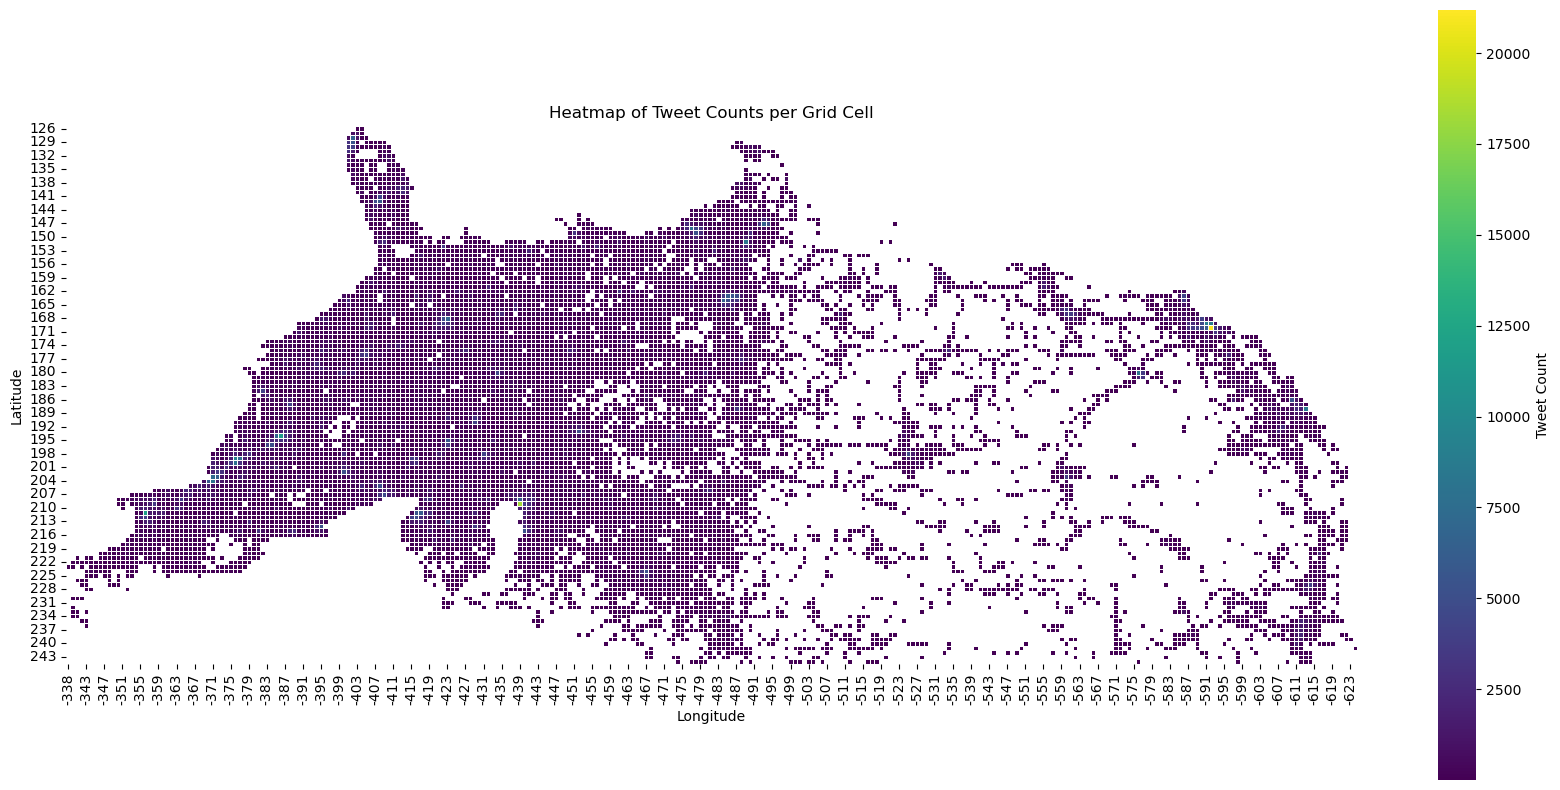

In [407]:
# Creating a heatmap of latitude and longitude from 'gridId'
dailyTweetCounts[['lat', 'lon']] = dailyTweetCounts['gridId'].str.extract(r'lat_(\d+)_lon_(-\d+)')

heatmap_data = dailyTweetCounts.pivot_table(index='lat', columns='lon', values='tweetCount', aggfunc='mean')

plt.figure(figsize=(17, 8))
sns.heatmap(heatmap_data, annot=False, cmap='viridis', linewidths=0.5, cbar_kws={'label': 'Tweet Count'}, square=True)
plt.title('Heatmap of Tweet Counts per Grid Cell')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()

In [408]:
numericalFeatures = ['tweetCount', 'dayOfWeek'] + [col for col in dailyTweetCounts.columns if
                        'tweetCountLag' in col]

In [409]:
#Scaling the columns using standard scalar
scaler = StandardScaler()
dailyTweetCounts[numericalFeatures] = scaler.fit_transform(dailyTweetCounts[numericalFeatures])

In [410]:
print("\nProcessed Data After Scaling:")
print(dailyTweetCounts.head())


Processed Data After Scaling:
             gridId       date  tweetCount  dayOfWeek  tweetCountLag_1  \
2  lat_126_lon_-403 2013-01-14   -0.293562  -1.457368        -0.294071   
3  lat_126_lon_-403 2013-01-17   -0.289209   0.668258        -0.296920   
6  lat_126_lon_-404 2013-01-15   -0.293562  -0.748826        -0.295495   
7  lat_126_lon_-404 2013-01-16   -0.293562  -0.040284        -0.296920   
8  lat_126_lon_-404 2013-01-17   -0.289209   0.668258        -0.296920   

   tweetCountLag_2  lat   lon  
2        -0.292068  126  -403  
3        -0.293483  126  -403  
6        -0.296313  126  -404  
7        -0.294898  126  -404  
8        -0.296313  126  -404  


In [411]:
print(dailyTweetCounts.info())

<class 'pandas.core.frame.DataFrame'>
Index: 49160 entries, 2 to 75551
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   gridId           49160 non-null  object        
 1   date             49160 non-null  datetime64[ns]
 2   tweetCount       49160 non-null  float64       
 3   dayOfWeek        49160 non-null  float64       
 4   tweetCountLag_1  49160 non-null  float64       
 5   tweetCountLag_2  49160 non-null  float64       
 6   lat              49160 non-null  object        
 7   lon              49160 non-null  object        
dtypes: datetime64[ns](1), float64(4), object(3)
memory usage: 3.4+ MB
None


In [412]:
dailyTweetCounts = dailyTweetCounts.dropna()

In [413]:
def dataPreparationForModel(df, gridId, sequenceLength, lagPeriods):
    
    cellData = df[df['gridId'] == gridId].copy()
    cellData = cellData.reset_index(drop=True)  
    
    if len(cellData) < sequenceLength:
        return np.array([]), np.array([])

    
    numericalFeatures = ['tweetCount', 'dayOfWeek'] + [col for col in cellData.columns if 'tweetCountLag' in col]
    cellData = cellData[numericalFeatures]
    
    X, y = [], []
    maxLag = max(lagPeriods) if lagPeriods else 0 
    startIndex = maxLag

    for i in range(startIndex + sequenceLength, len(cellData)):
        sequence = cellData.iloc[i - sequenceLength:i].values
        if np.isnan(sequence).any(): 
            print(f"Skipping sequence at index {i} due to the presence of NaN values")
            continue
        X.append(sequence)
        y.append(cellData.iloc[i, 0])
    

    return np.array(X), np.array(y)

In [414]:
sequenceLength = 2
Xcells, ycells = {}, {}

for cellId in dailyTweetCounts['gridId'].unique():
    X, y = dataPreparationForModel(dailyTweetCounts, cellId, sequenceLength, lagPeriods)
    if len(X) > 0:
        Xcells[cellId] = X
        ycells[cellId] = y

print(f"Number of cells with valid data in X: {len(Xcells)}")

Number of cells with valid data in X: 8197


In [415]:
X = np.concatenate(list(Xcells.values()), axis=0)
y = np.concatenate(list(ycells.values()), axis=0)

print(f"Shape of X: {X.shape}, Shape of y: {y.shape}")

Shape of X: (8197, 2, 4), Shape of y: (8197,)


In [416]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=30)
print(f"Training data shape: {X_train.shape}, Test data shape: {X_test.shape}")

Training data shape: (5737, 2, 4), Test data shape: (2460, 2, 4)


In [417]:
X_trainReshape = X_train.reshape(X_train.shape[0], -1)
X_testReshape = X_test.reshape(X_test.shape[0], -1)

# Multi-Layer Perceptron

In [418]:
model_mlp = Sequential()
model_mlp.add(Dense(16, activation='relu', input_shape=(X_trainReshape.shape[1],)))  # Input layer
model_mlp.add(Dropout(0.3))  # Add dropout
model_mlp.add(Dense(16, activation='relu'))  # Hidden layer
model_mlp.add(Dropout(0.3))
model_mlp.add(Dense(1))  # Output layer

/Users/tinkuacchu/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [419]:
model_mlp.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [420]:
start = time.time()
historyMLP = model_mlp.fit(X_trainReshape, y_train, epochs=20, batch_size=64, validation_data=(X_testReshape, y_test))
end = time.time()
timeMLP = end - start

Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.8626 - mae: 0.4336 - val_loss: 0.3060 - val_mae: 0.1793
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 621us/step - loss: 0.3361 - mae: 0.2180 - val_loss: 0.2093 - val_mae: 0.1528
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step - loss: 0.2807 - mae: 0.2020 - val_loss: 0.2025 - val_mae: 0.1531
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step - loss: 0.2982 - mae: 0.1969 - val_loss: 0.1884 - val_mae: 0.1478
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step - loss: 0.2316 - mae: 0.1857 - val_loss: 0.2006 - val_mae: 0.1420
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step - loss: 0.1780 - mae: 0.1619 - val_loss: 0.1443 - val_mae: 0.1331
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step - loss: 0.1327 - mae: 0.1575 - val_loss: 0.1417 - val_mae: 0.1282
Epoch 8/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step - loss: 0.1495 - mae: 0.1534 - val_loss: 0.1240 - val_mae: 0.1324
Epoch 9/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step - loss

In [421]:
mseMLP = mean_squared_error(y_test, y_pred)
maeMLP = mean_absolute_error(y_test, y_pred)
rsquareMLP = r2_score(y_test, y_pred)

print(f"MLP Model - Mean Squared Error: {mseMLP}")
print(f"MLP Model - Mean Absolute Error: {maeMLP}")
print(f"MLP Model - R-Square Score: {rsquareMLP}")

MLP Model - Mean Squared Error: 0.05439714675040217
MLP Model - Mean Absolute Error: 0.10711203983892303
MLP Model - R-Square Score: 0.9673893168135725


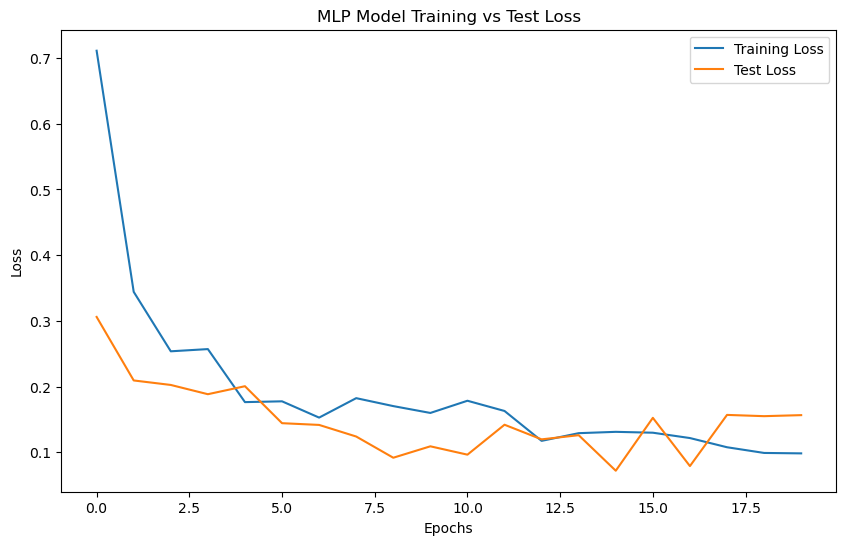

In [422]:
plt.figure(figsize=(10, 6))
plt.plot(historyMLP.history['loss'], label='Training Loss')
plt.plot(historyMLP.history['val_loss'], label='Test Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('MLP Model Training vs Test Loss')
plt.legend()

plt.show()

# Convolution Neural Network

In [423]:
X_trainReshapedCNN = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_testReshapedCNN = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [424]:
# Build the CNN model without MaxPooling1D layer
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(X_trainReshapedCNN.shape[1], X_trainReshapedCNN.shape[2])))
cnn_model.add(MaxPooling1D(pool_size=1))
cnn_model.add(Dropout(0.3))
cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dropout(0.3))
cnn_model.add(Dense(units=1))

/Users/tinkuacchu/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [425]:
cnn_model.compile(optimizer='adam', loss='mean_squared_error')

In [426]:
start = time.time()
historyCNN = cnn_model.fit(X_trainReshapedCNN, y_train, epochs=20, batch_size=64, validation_data=(X_testReshapedCNN, y_test))
end = time.time()
timeCNN = end - start

Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2122 - val_loss: 0.0232
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - loss: 0.0656 - val_loss: 0.0199
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - loss: 0.0545 - val_loss: 0.0317
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - loss: 0.0760 - val_loss: 0.0215
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - loss: 0.0567 - val_loss: 0.0382
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - loss: 0.0457 - val_loss: 0.0353
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - loss: 0.0703 - val_loss: 0.0433
Epoch 8/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - loss: 0.0398 - val_loss: 0.0532
Epoch 9/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - loss: 0.0391 - val_loss: 0.0478
Epoch 10/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - loss: 0.0340 - val_loss: 0.0199
Epoch 11/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step - loss: 0.0568 - val_loss: 0.0217
Epoch 12/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step -

In [427]:
y_pred_cnn = cnn_model.predict(X_testReshapedCNN)

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step


In [428]:
mseCNN = mean_squared_error(y_test, y_pred_cnn)
maeCNN = mean_absolute_error(y_test, y_pred_cnn)
rsquareCNN = r2_score(y_test, y_pred_cnn)

print(f"CNN Model - Mean Squared Error: {mseCNN}")
print(f"CNN Model - Mean Absolute Error: {maeCNN}")
print(f"CNN Model - R-Square Score: {rsquareCNN}")

CNN Model - Mean Squared Error: 0.22147954707302506
CNN Model - Mean Absolute Error: 0.11245319035263494
CNN Model - R-Square Score: 0.8672246657529243


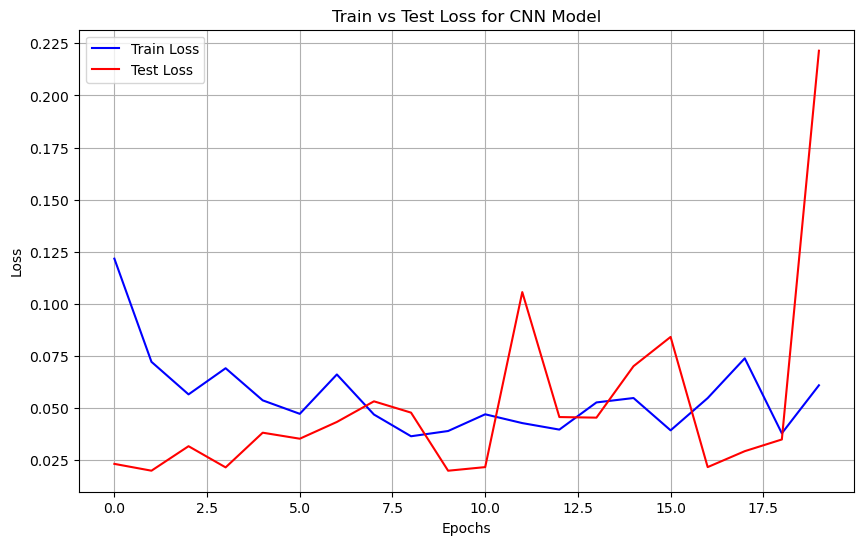

In [429]:
# Plotting train vs test loss
plt.figure(figsize=(10, 6))
plt.plot(historyCNN.history['loss'], label='Train Loss', color='blue')
plt.plot(historyCNN.history['val_loss'], label='Test Loss', color='red')
plt.title('Train vs Test Loss for CNN Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Recurrent Neural Network

In [430]:
rnn_model = Sequential()
rnn_model.add(SimpleRNN(units=64, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
rnn_model.add(Dropout(0.3))
rnn_model.add(Dense(1)) 

/Users/tinkuacchu/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [431]:
rnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [432]:
start = time.time()
historyRNN = rnn_model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test), verbose=1)
end = time.time()
timeRNN = end - start

Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5198 - mae: 0.2694 - val_loss: 0.5186 - val_mae: 0.0953
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step - loss: 0.0889 - mae: 0.1249 - val_loss: 0.4055 - val_mae: 0.1099
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - loss: 0.1279 - mae: 0.1092 - val_loss: 0.3362 - val_mae: 0.0779
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step - loss: 0.0511 - mae: 0.0931 - val_loss: 0.2992 - val_mae: 0.0814
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step - loss: 0.0917 - mae: 0.0949 - val_loss: 0.2640 - val_mae: 0.0689
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - loss: 0.0438 - mae: 0.0824 - val_loss: 0.2479 - val_mae: 0.0886
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step - loss: 0.0478 - mae: 0.0833 - val_loss: 0.2293 - val_mae: 0.0665
Epoch 8/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - loss: 0.0321 - mae: 0.0760 - val_loss: 0.2171 - val_mae: 0.0662
Epoch 9/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step - loss

In [433]:
y_pred_rnn = rnn_model.predict(X_test).flatten()

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step


In [434]:
mseRNN = mean_squared_error(y_test, y_pred_rnn)
maeRNN = mean_absolute_error(y_test, y_pred_rnn)
rsquareRNN = r2_score(y_test, y_pred_rnn)

print(f"RNN Model - Mean Squared Error: {mseRNN}")
print(f"RNN Model - Mean Absolute Error: {maeRNN}")
print(f"RNN Model - R-Square Score: {rsquareRNN}")

RNN Model - Mean Squared Error: 0.13721823565798763
RNN Model - Mean Absolute Error: 0.057978140742715435
RNN Model - R-Square Score: 0.9177386926013708


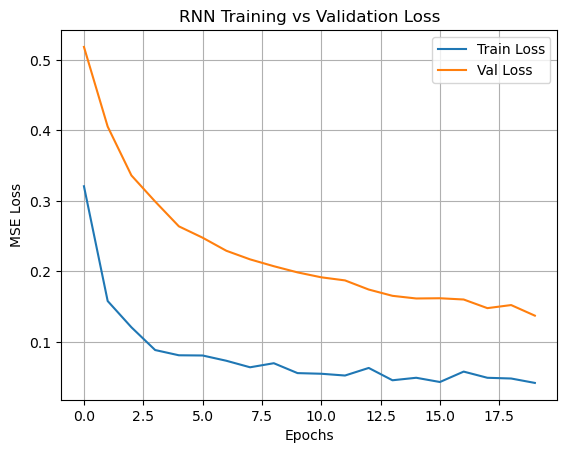

In [435]:
plt.plot(historyRNN.history['loss'], label='Train Loss')
plt.plot(historyRNN.history['val_loss'], label='Val Loss')
plt.title('RNN Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

# GRU Model

In [436]:
gru_model = Sequential()
gru_model.add(GRU(units=64, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
gru_model.add(Dropout(0.3))
gru_model.add(Dense(1))

/Users/tinkuacchu/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [437]:
gru_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [438]:
start = time.time()
historyGRU = gru_model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test),verbose=1)
end=time.time()
timeGRU = end - start

Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4436 - mae: 0.2063 - val_loss: 0.4645 - val_mae: 0.0897
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1499 - mae: 0.1014 - val_loss: 0.3502 - val_mae: 0.0828
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1432 - mae: 0.0819 - val_loss: 0.3008 - val_mae: 0.0755
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0930 - mae: 0.0764 - val_loss: 0.2690 - val_mae: 0.0708
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1378 - mae: 0.0814 - val_loss: 0.2538 - val_mae: 0.0824
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0363 - mae: 0.0700 - val_loss: 0.2264 - val_mae: 0.0657
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0468 - mae: 0.0668 - val_loss: 0.2112 - val_mae: 0.0685
Epoch 8/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0317 - mae: 0.0690 - val_loss: 0.2003 - val_mae: 0.0629
Epoch 9/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0503 - mae: 

In [439]:
y_pred_gru = gru_model.predict(X_test).flatten()

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


In [440]:
mseGRU = mean_squared_error(y_test, y_pred_gru)
maeGRU = mean_absolute_error(y_test, y_pred_gru)
rsquareGRU = r2_score(y_test, y_pred_gru)

print(f"GRU Model - Mean Squared Error: {mseGRU}")
print(f"GRU Model - Mean Absolute Error: {maeGRU}")
print(f"GRU Model - R-Square Score: {rsquareGRU}")

GRU Model - Mean Squared Error: 0.13921462532308596
GRU Model - Mean Absolute Error: 0.07633739721259958
GRU Model - R-Square Score: 0.9165418719081108


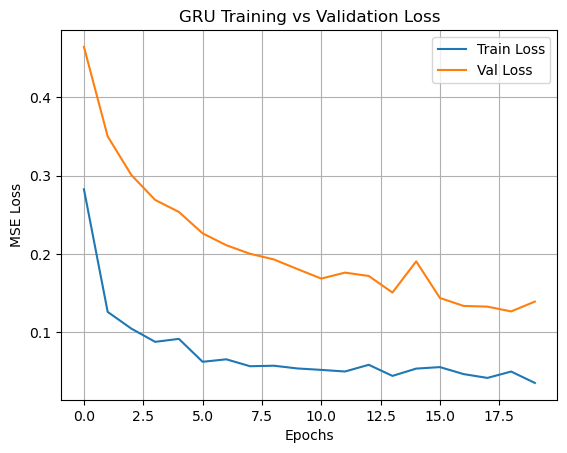

In [441]:
plt.plot(historyGRU.history['loss'], label='Train Loss')
plt.plot(historyGRU.history['val_loss'], label='Val Loss')
plt.title('GRU Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

# BI-LSTM Model

In [442]:
bilstm_model = Sequential()
bilstm_model.add(Bidirectional(LSTM(units=64, return_sequences=False), input_shape=(X_train.shape[1], X_train.shape[2])))
bilstm_model.add(Dropout(0.3))
bilstm_model.add(Dense(1))  # Output layer

/Users/tinkuacchu/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [443]:
bilstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [444]:
start = time.time()
historyBILSTM = bilstm_model.fit(X_train, y_train,epochs=20, batch_size=64, validation_data=(X_test, y_test), verbose=1)
end=time.time()
timeBI = end - start

Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6980 - mae: 0.2507 - val_loss: 0.4996 - val_mae: 0.0899
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1148 - mae: 0.0833 - val_loss: 0.2668 - val_mae: 0.0898
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0346 - mae: 0.0752 - val_loss: 0.2259 - val_mae: 0.0802
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0923 - mae: 0.0727 - val_loss: 0.1966 - val_mae: 0.0789
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0415 - mae: 0.0663 - val_loss: 0.1664 - val_mae: 0.0687
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0510 - mae: 0.0654 - val_loss: 0.1487 - val_mae: 0.0610
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0214 - mae: 0.0603 - val_loss: 0.1333 - val_mae: 0.0580
Epoch 8/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0635 - mae: 0.0617 - val_loss: 0.1346 - val_mae: 0.0670
Epoch 9/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0397 - mae: 

In [445]:
y_pred_bilstm = bilstm_model.predict(X_test).flatten()

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [446]:
# Metrics
mseBILSTM = mean_squared_error(y_test, y_pred_bilstm)
maeBILSTM = mean_absolute_error(y_test, y_pred_bilstm)
rsquareBILSTM = r2_score(y_test, y_pred_bilstm)

print(f"BILSTM Model - Mean Squared Error: {mseBILSTM}")
print(f"BILSTM Model - Mean Absolute Error: {maeBILSTM}")
print(f"BILSTM Model - R-Square Score: {rsquareBILSTM}")

BILSTM Model - Mean Squared Error: 0.06877253087147737
BILSTM Model - Mean Absolute Error: 0.06203900145186404
BILSTM Model - R-Square Score: 0.9587713814022429


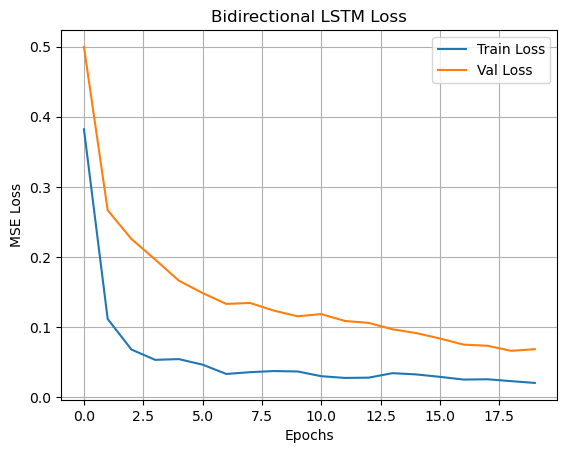

In [447]:
plt.plot(historyBILSTM.history['loss'], label='Train Loss')
plt.plot(historyBILSTM.history['val_loss'], label='Val Loss')
plt.title('Bidirectional LSTM Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

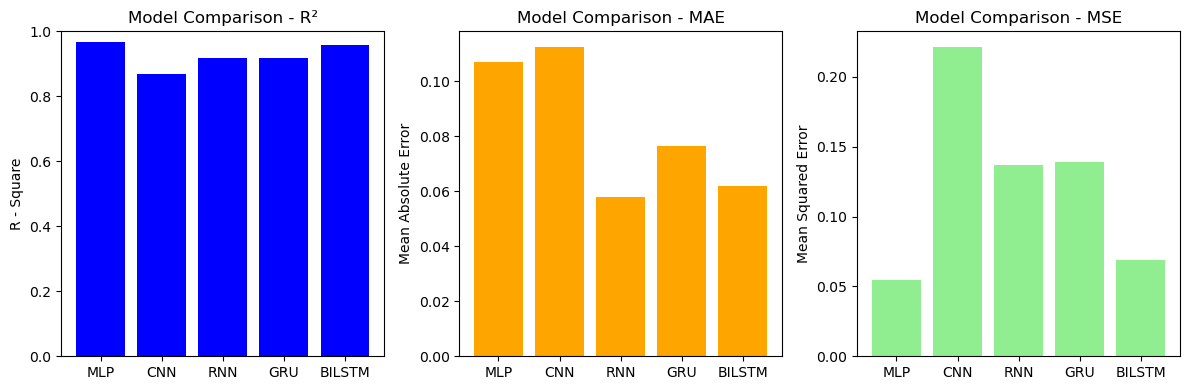

In [448]:
models = ['MLP', 'CNN', 'RNN', 'GRU', 'BILSTM']
r2_scores = [rsquareMLP, rsquareCNN, rsquareRNN, rsquareGRU, rsquareBILSTM]
mae_scores = [maeMLP, maeCNN, maeRNN, maeGRU, maeBILSTM]
mse_scores = [mseMLP, mseCNN, mseRNN, mseGRU, mseBILSTM]

# Create subplots side by side
fig, axs = plt.subplots(1, 3, figsize=(12, 4))  # 1 row, 3 columns

# R² Plot
axs[0].bar(models, r2_scores, color='blue')
axs[0].set_ylabel('R - Square')
axs[0].set_title('Model Comparison - R²')
axs[0].set_ylim(0, 1)

# MAE Plot
axs[1].bar(models, mae_scores, color='orange')
axs[1].set_ylabel('Mean Absolute Error')
axs[1].set_title('Model Comparison - MAE')

# MSE Plot
axs[2].bar(models, mse_scores, color='lightgreen')
axs[2].set_ylabel('Mean Squared Error')
axs[2].set_title('Model Comparison - MSE')

plt.tight_layout()
plt.show()

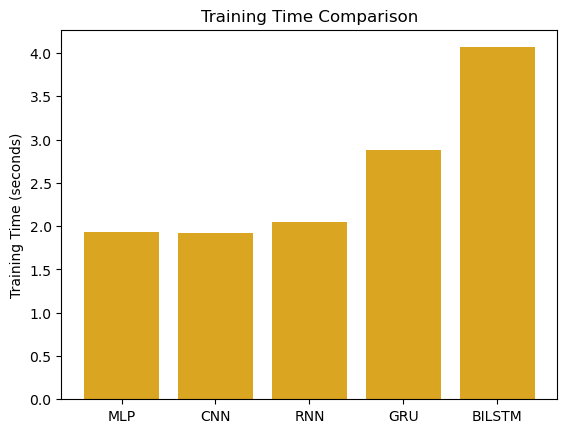

In [449]:
training_times = [timeMLP, timeCNN, timeRNN, timeGRU, timeBI]
plt.bar(models, training_times, color='goldenrod')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time Comparison')
plt.show()

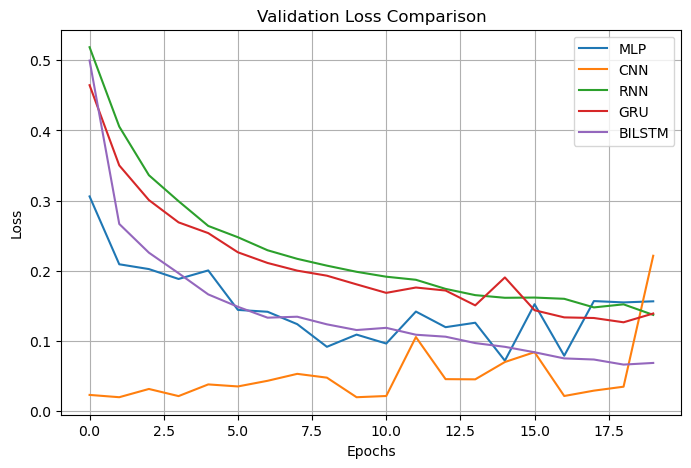

In [450]:
plt.figure(figsize=(8, 5))
plt.plot(historyMLP.history['val_loss'], label='MLP')
plt.plot(historyCNN.history['val_loss'], label='CNN')
plt.plot(historyRNN.history['val_loss'], label='RNN')
plt.plot(historyGRU.history['val_loss'], label='GRU')
plt.plot(historyBILSTM.history['val_loss'], label='BILSTM')
plt.title('Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()